# ACS2 vs ACS2ER in Multiplexer

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from lcs.metrics import population_metrics
from lcs.agents.EnvironmentAdapter import EnvironmentAdapter

# Enable automatic module reload
# %load_ext autoreload
# %autoreload 2

# Load environments
import gym
import gym_maze

from lcs.agents.acs2 import ACS2, Configuration as CFG_ACS2
from lcs.agents.acs2er import ACS2ER, Configuration as CFG_ACS2ER, ReplayMemory, ReplayMemorySample
from lcs.agents.acs2eer import ACS2EER, Configuration as CFG_ACS2EER

# To avoid Type3 fonts in generated pdf file
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Logger
import logging
logging.basicConfig(level=logging.INFO)


# EXPERIMENT CONFIGURATION

In [2]:
# # Custom function for obtaining available environments
# filter_envs = lambda env: env.id.startswith("Maze") or env.id.startswith("Woods")

# all_envs = [env for env in gym.envs.registry.all()]
# maze_envs = [env for env in all_envs if filter_envs(env)]

# for env in maze_envs:
#     print("Maze ID: [{}], non-deterministic: [{}]".format(env.id, env.nondeterministic, ))

# # Initialize environment
# maze = gym.make('Maze7-v0')

# # Reset it, by putting an agent into random position
# situation = maze.reset()

# # Render the state in ASCII
# maze.render()

In [3]:
MAZE = "MazeZ-v0" 

EXPLORE_TRIALS = 3000
EXPLOIT_TRIALS = 500

# The size of ER replay memory buffer
ER_BUFFER_SIZE=40000
# The minimum number of samples of ER replay memory buffer to start replying samples (warm-up phase)
ER_BUFFER_MIN_SAMPLES=1000
# The number of samples to be replayed druing ER phase
ER_SAMPLES_NUMBER=1


## Metrics and helpers

In [4]:
def _get_transitions():
    knowledge_env = gym.make(MAZE)
    transitions = knowledge_env.env.get_transitions()
    transitions = list(map(lambda t: [knowledge_env.env.maze.perception(t[0]), t[1], knowledge_env.env.maze.perception(t[2])], transitions))

    return transitions

TRANSITIONS = _get_transitions()
TRANSITIONS_LENGTH = len(TRANSITIONS)
def _maze_knowledge(population) -> float:
    # Take into consideration only reliable classifiers
    reliable_classifiers = [c for c in population if c.is_reliable()]

    # Count how many transitions are anticipated correctly
    nr_correct = 0

    # For all possible destinations from each path cell
    for p0, action, p1 in TRANSITIONS:
        if any([True for cl in reliable_classifiers
                if cl.predicts_successfully(p0, action, p1)]):
            nr_correct += 1

    return nr_correct / TRANSITIONS_LENGTH * 100.0

def _maze_metrics(agent, env):
    pop = agent.population
    metrics = {
        'knowledge': _maze_knowledge(pop)
    }

    # Add basic population metrics
    metrics.update(population_metrics(pop, env))
    
    return metrics

def parse_metrics_to_df(explore_metrics, exploit_metrics):
    def extract_details(row):
        row['trial'] = row['trial']
        row['steps'] = row['steps_in_trial']
        row['numerosity'] = row['numerosity']
        row['reliable'] = row['reliable']
        row['knowledge'] = row['knowledge']
        return row
    
    # Load both metrics into data frame
    explore_df = pd.DataFrame(explore_metrics)
    exploit_df = pd.DataFrame(exploit_metrics)
    
    # Mark them with specific phase
    explore_df['phase'] = 'explore'
    exploit_df['phase'] = 'exploit'
    
    # Extract details
    explore_df = explore_df.apply(extract_details, axis=1)
    exploit_df = exploit_df.apply(extract_details, axis=1)
    
    # Adjuts exploit trial counter
    exploit_df['trial'] = exploit_df.apply(lambda r: r['trial']+len(explore_df), axis=1)
    
    # Concatenate both dataframes
    df = pd.concat([explore_df, exploit_df])
    df.set_index('trial', inplace=True)
    
    return df

def find_best_classifier(population, situation):
    match_set = population.form_match_set(situation)
    anticipated_change_cls = [cl for cl in match_set if cl.does_anticipate_change()]
    
    if (len(anticipated_change_cls) > 0):
        return max(anticipated_change_cls, key=lambda cl: cl.fitness)
    
    return None

def build_fitness_matrix(env, population):
    original = env.env.maze.matrix
    fitness = original.copy()
    
    # Think about more 'functional' way of doing this
    for index, x in np.ndenumerate(original):
        # Path - best classfier fitness
        if x == 0:
            perception = env.env.maze.perception(index)
            best_cl = find_best_classifier(population, perception)
            if best_cl:
                fitness[index] = best_cl.fitness
            else:
                fitness[index] = -1
        
        # Wall - fitness = 0
        if x == 1:
            fitness[index] = 0
        
        # Reward - inf fitness
        if x == 9:
            fitness[index] = fitness.max () + 500
        
    return fitness
    
def build_action_matrix(env, population):
    ACTION_LOOKUP = { 
        0: u'↑', 1: u'↗', 2: u'→', 3: u'↘',
        4: u'↓', 5: u'↙', 6: u'←', 7: u'↖'
    }
    
    original = env.env.maze.matrix
    action = original.copy().astype(str)
    
    # Think about more 'functional' way of doing this
    for index, x in np.ndenumerate(original):
        # Path - best classfier fitness
        if x == 0:
            perception = env.env.maze.perception(index)
            best_cl = find_best_classifier(population, perception)
            if best_cl:
                action[index] = ACTION_LOOKUP[best_cl.action]
            else:
                action[index] = '?'
        
        # Wall - fitness = 0
        if x == 1:
            action[index] = '\#'
        
        # Reward - inf fitness
        if x == 9:
            action[index] = 'R'
        
    return action


# Plot constants
TITLE_TEXT_SIZE=24
AXIS_TEXT_SIZE=18
LEGEND_TEXT_SIZE=16


def plot_policy(env, agent, ax=None):
    if ax is None:
        ax = plt.gca()
    
    ax.set_aspect("equal")
    
    # Handy variables
    max_x, max_y = env.env.maze.matrix.shape
    
    fitness_matrix = build_fitness_matrix(env, agent.population)
    action_matrix = build_action_matrix(env, agent.population)
    
    # Render maze as image
    plt.imshow(fitness_matrix, interpolation='nearest', cmap='Reds', aspect='auto', extent=[0, max_x, max_y, 0])
    
    
    # Add labels to each cell
    for (y,x), val in np.ndenumerate(action_matrix):
        plt.text(x+0.4, y+0.5, "${}$".format(val))
    
    ax.set_title("Policy", fontsize=TITLE_TEXT_SIZE)
    ax.set_xlabel('x', fontsize=AXIS_TEXT_SIZE)
    ax.set_ylabel('y', fontsize=AXIS_TEXT_SIZE)

    ax.set_xlim(0, max_x)
    ax.set_ylim(max_y, 0)
    
    ax.set_xticks(range(0, max_x))
    ax.set_yticks(range(0, max_y))
    
    ax.grid(True)



def plot_knowledge(df, ax=None):
    if ax is None:
        ax = plt.gca()
    
    explore_df = df.query("phase == 'explore'")
    exploit_df = df.query("phase == 'exploit'")
        
    explore_df['knowledge'].plot(ax=ax, c='blue')
    exploit_df['knowledge'].plot(ax=ax, c='red')
    ax.axvline(x=len(explore_df), c='black', linestyle='dashed')
        
    ax.set_title("Achieved knowledge", fontsize=TITLE_TEXT_SIZE)
    ax.set_xlabel("Trial", fontsize=AXIS_TEXT_SIZE)
    ax.set_ylabel("Knowledge [%]", fontsize=AXIS_TEXT_SIZE)
    ax.set_ylim([0, 105])


def plot_steps(df, ax=None):
    if ax is None:
        ax = plt.gca()
    
    explore_df = df.query("phase == 'explore'")
    exploit_df = df.query("phase == 'exploit'")
    
    explore_df['steps'].plot(ax=ax, c='blue', linewidth=.5)
    exploit_df['steps'].plot(ax=ax, c='red', linewidth=0.5)
    ax.axvline(x=len(explore_df), c='black', linestyle='dashed')
    
    ax.set_title("Steps", fontsize=TITLE_TEXT_SIZE)
    ax.set_xlabel("Trial", fontsize=AXIS_TEXT_SIZE)
    ax.set_ylabel("Steps", fontsize=AXIS_TEXT_SIZE)


def plot_classifiers(df, ax=None):
    if ax is None:
        ax = plt.gca()
    
    explore_df = df.query("phase == 'explore'")
    exploit_df = df.query("phase == 'exploit'")
    
    df['numerosity'].plot(ax=ax, c='blue')
    df['reliable'].plot(ax=ax, c='red')    
    
    ax.axvline(x=len(explore_df), c='black', linestyle='dashed')
    
    ax.set_title("Classifiers", fontsize=TITLE_TEXT_SIZE)
    ax.set_xlabel("Trial", fontsize=AXIS_TEXT_SIZE)
    ax.set_ylabel("Classifiers", fontsize=AXIS_TEXT_SIZE)
    ax.legend(fontsize=LEGEND_TEXT_SIZE)


def plot_performance(agent, maze, metrics_df, env_name, agent_name):
    plt.figure(figsize=(13, 10), dpi=100)
    plt.suptitle(f'{agent_name} Performance in {env_name} environment', fontsize=32)
    
    ax1 = plt.subplot(221)
    plot_policy(maze, agent, ax1)
    
    ax2 = plt.subplot(222)
    plot_knowledge(metrics_df, ax2)
    
    ax3 = plt.subplot(223)
    plot_classifiers(metrics_df, ax3)
    
    ax4 = plt.subplot(224)
    plot_steps(metrics_df, ax4)
    
    plt.subplots_adjust(top=0.86, wspace=0.3, hspace=0.3)

<>:122: DeprecationWarning: invalid escape sequence \#


### Results arrays

ACS2 Experiments

In [5]:

### ACS2 ###
# Load desired environment
maze_acs2 = gym.make(MAZE)
# Create agent 
cfg_acs2 = CFG_ACS2(    
    classifier_length=8,
    number_of_possible_actions=8,
    metrics_trial_frequency=1,
    user_metrics_collector_fcn=_maze_metrics)
agent_acs2 = ACS2(cfg_acs2)
# Explore the environment
acs2_explore_metrics = agent_acs2.explore(maze_acs2, EXPLORE_TRIALS)
# Exploit the environment
acs2_exploit_metrics = agent_acs2.exploit(maze_acs2, EXPLOIT_TRIALS)


INFO:lcs.agents.Agent:{'trial': 300, 'steps_in_trial': 11, 'reward': 1000, 'perf_time': 0.036684300000004555, 'knowledge': 28.82882882882883, 'population': 924, 'numerosity': 924, 'reliable': 216}
INFO:lcs.agents.Agent:{'trial': 600, 'steps_in_trial': 10, 'reward': 1000, 'perf_time': 0.03316639999999893, 'knowledge': 48.048048048048045, 'population': 949, 'numerosity': 949, 'reliable': 348}
INFO:lcs.agents.Agent:{'trial': 900, 'steps_in_trial': 19, 'reward': 1000, 'perf_time': 0.053331200000002354, 'knowledge': 60.36036036036037, 'population': 884, 'numerosity': 884, 'reliable': 436}
INFO:lcs.agents.Agent:{'trial': 1200, 'steps_in_trial': 1, 'reward': 1000, 'perf_time': 0.0030598999999824628, 'knowledge': 64.86486486486487, 'population': 863, 'numerosity': 863, 'reliable': 479}
INFO:lcs.agents.Agent:{'trial': 1500, 'steps_in_trial': 35, 'reward': 1000, 'perf_time': 0.16354899999998906, 'knowledge': 70.57057057057057, 'population': 851, 'numerosity': 851, 'reliable': 511}
INFO:lcs.agent

ACS2ER Experiments

In [6]:
### ACS2EER ###
# Load desired environment
maze_acs2rer = gym.make(MAZE)
# Create agent ACS2ER
cfg_acs2rer = CFG_ACS2EER(    
    classifier_length=8,
    number_of_possible_actions=8,
    metrics_trial_frequency=1,
    er_buffer_size=ER_BUFFER_SIZE,
    er_min_samples=ER_BUFFER_MIN_SAMPLES / 40,
    er_samples_number=ER_SAMPLES_NUMBER,
    user_metrics_collector_fcn=_maze_metrics)
agent_acs2rer = ACS2EER(cfg_acs2rer)
# Explore the environment
acs2rer_explore_metrics = agent_acs2rer.explore(maze_acs2rer, EXPLORE_TRIALS)
# Exploit the environment
acs2rer_exploit_metrics = agent_acs2rer.exploit(maze_acs2rer, EXPLOIT_TRIALS)

INFO:lcs.agents.Agent:{'trial': 300, 'steps_in_trial': 50, 'reward': 0, 'perf_time': 0.5368235000000823, 'knowledge': 36.03603603603604, 'population': 1137, 'numerosity': 1137, 'reliable': 278}
INFO:lcs.agents.Agent:{'trial': 600, 'steps_in_trial': 50, 'reward': 0, 'perf_time': 0.5279468999999608, 'knowledge': 61.56156156156156, 'population': 1019, 'numerosity': 1019, 'reliable': 519}
INFO:lcs.agents.Agent:{'trial': 900, 'steps_in_trial': 12, 'reward': 1000, 'perf_time': 0.32762800000000425, 'knowledge': 72.67267267267268, 'population': 973, 'numerosity': 973, 'reliable': 613}
INFO:lcs.agents.Agent:{'trial': 1200, 'steps_in_trial': 29, 'reward': 1000, 'perf_time': 0.42326890000003914, 'knowledge': 78.37837837837837, 'population': 932, 'numerosity': 932, 'reliable': 663}
INFO:lcs.agents.Agent:{'trial': 1500, 'steps_in_trial': 50, 'reward': 0, 'perf_time': 0.3566203999998834, 'knowledge': 82.58258258258259, 'population': 905, 'numerosity': 905, 'reliable': 698}
INFO:lcs.agents.Agent:{'tr

In [7]:

### ACS2ER ###
# Load desired environment
maze_acs2er = gym.make(MAZE)
# Create agent ACS2ER
cfg_acs2er = CFG_ACS2ER(    
    classifier_length=8,
    number_of_possible_actions=8,
    metrics_trial_frequency=1,
    er_buffer_size=ER_BUFFER_SIZE,
    er_min_samples=ER_BUFFER_MIN_SAMPLES,
    er_samples_number=ER_SAMPLES_NUMBER,
    user_metrics_collector_fcn=_maze_metrics)
agent_acs2er = ACS2ER(cfg_acs2er)
# Explore the environment
acs2er_explore_metrics = agent_acs2er.explore(maze_acs2er, EXPLORE_TRIALS)
# Exploit the environment
acs2er_exploit_metrics = agent_acs2er.exploit(maze_acs2er, EXPLOIT_TRIALS)

    

INFO:lcs.agents.Agent:{'trial': 300, 'steps_in_trial': 50, 'reward': 0, 'perf_time': 0.6149462000003041, 'knowledge': 40.24024024024024, 'population': 1208, 'numerosity': 1208, 'reliable': 335}
INFO:lcs.agents.Agent:{'trial': 600, 'steps_in_trial': 50, 'reward': 0, 'perf_time': 0.571592000000237, 'knowledge': 57.65765765765766, 'population': 1118, 'numerosity': 1118, 'reliable': 524}
INFO:lcs.agents.Agent:{'trial': 900, 'steps_in_trial': 50, 'reward': 0, 'perf_time': 0.7397578999998586, 'knowledge': 68.76876876876878, 'population': 1042, 'numerosity': 1042, 'reliable': 625}
INFO:lcs.agents.Agent:{'trial': 1200, 'steps_in_trial': 50, 'reward': 0, 'perf_time': 0.6705360000000837, 'knowledge': 76.57657657657657, 'population': 995, 'numerosity': 995, 'reliable': 686}
INFO:lcs.agents.Agent:{'trial': 1500, 'steps_in_trial': 50, 'reward': 0, 'perf_time': 0.7141092000001663, 'knowledge': 81.38138138138137, 'population': 992, 'numerosity': 992, 'reliable': 718}
INFO:lcs.agents.Agent:{'trial': 1

In [8]:
# def _rm_update(rm: ReplayMemory, sample: ReplayMemorySample):
#     if(sample.reward == 0):
#         rm.update(sample)
#         return
    
#     for _ in range(5):
#         rm.update(ReplayMemorySample(sample.state, sample.action, sample.reward, sample.next_state, sample.done))

# def _rm_update_2(rm: ReplayMemory, sample: ReplayMemorySample):
#     if any(sample.state == s.state and sample.action == s.action and sample.reward == s.reward and sample.next_state == s.next_state and sample.done == s.done for s in rm):
#         # print("Sample Exists", sample)
#         return

#     rm.update(sample)


# ### ACS2pER ###
# # Load desired environment
# maze_acs2per = gym.make(MAZE)
# # Create agent ACS2ER
# cfg_acs2per = CFG_ACS2ER(    
#     classifier_length=8,
#     number_of_possible_actions=8,
#     metrics_trial_frequency=1,
#     er_buffer_size=ER_BUFFER_SIZE,
#     er_min_samples=ER_BUFFER_MIN_SAMPLES,
#     er_samples_number=ER_SAMPLES_NUMBER,
#     er_rm_update_func=_rm_update_2,
#     user_metrics_collector_fcn=_maze_metrics)
# agent_acs2per = ACS2ER(cfg_acs2per)
# # Explore the environment
# acs2per_explore_metrics = agent_acs2per.explore(maze_acs2per, EXPLORE_TRIALS)
# # Exploit the environment
# acs2per_exploit_metrics = agent_acs2per.exploit(maze_acs2per, EXPLOIT_TRIALS)

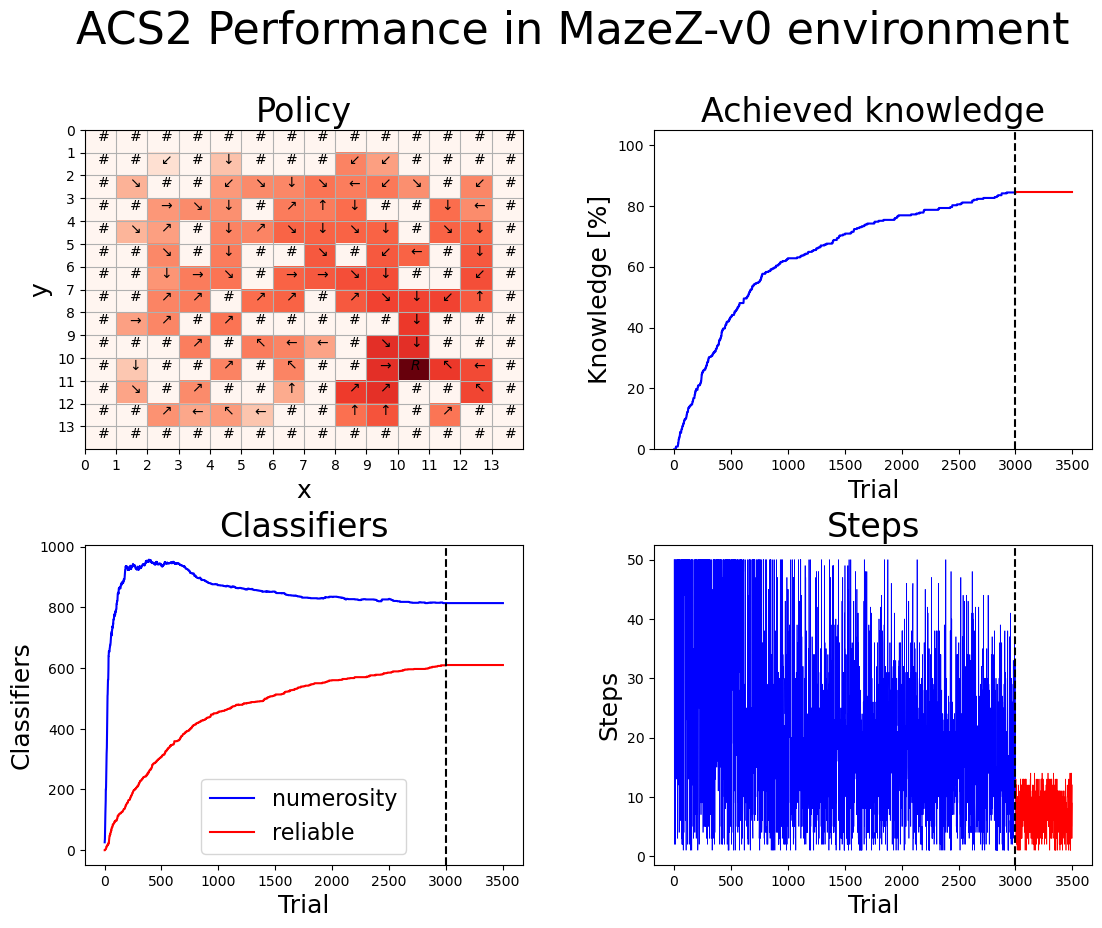

In [9]:
maze5_metrics_df_acs2 = parse_metrics_to_df(acs2_explore_metrics, acs2_exploit_metrics)
plot_performance(agent_acs2, maze_acs2, maze5_metrics_df_acs2, MAZE, 'ACS2')

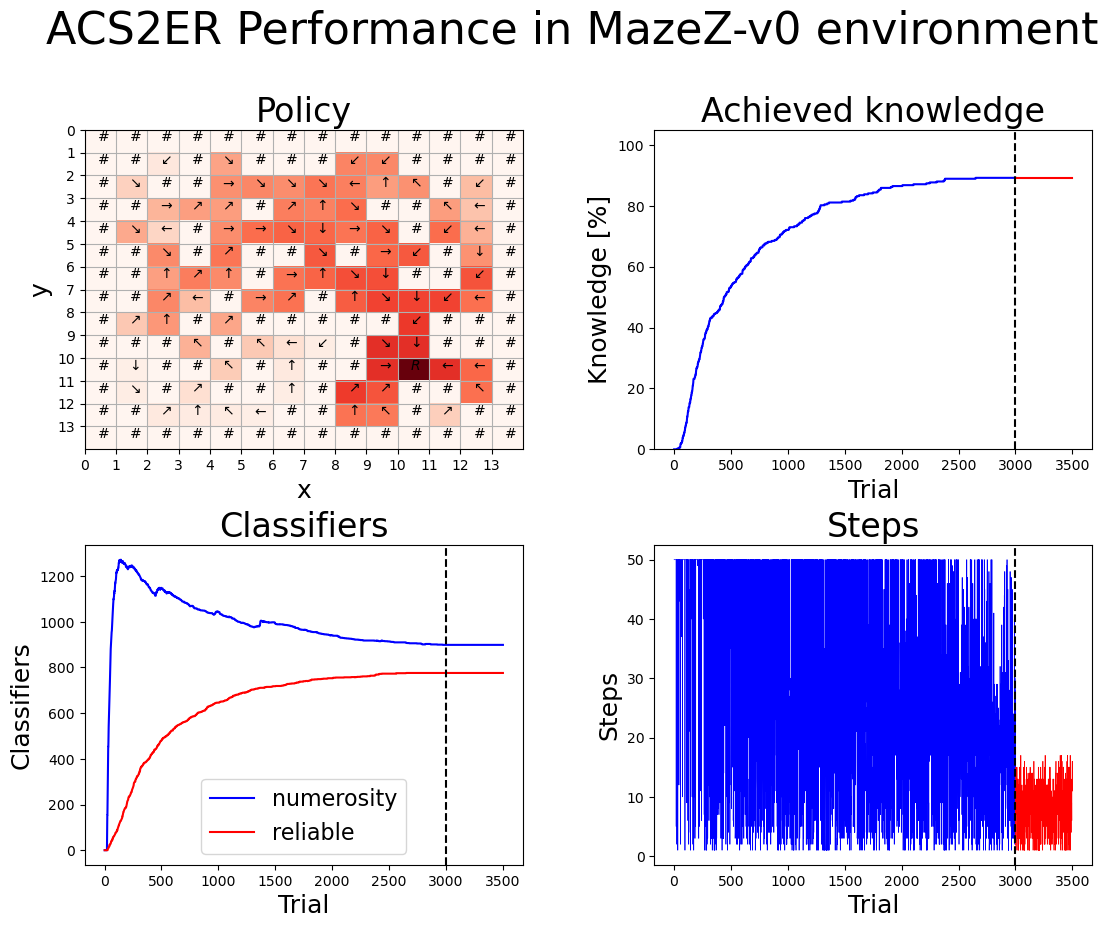

In [10]:
maze5_metrics_df_acs2er = parse_metrics_to_df(acs2er_explore_metrics, acs2er_exploit_metrics)
plot_performance(agent_acs2er, maze_acs2er, maze5_metrics_df_acs2er, MAZE, 'ACS2ER')

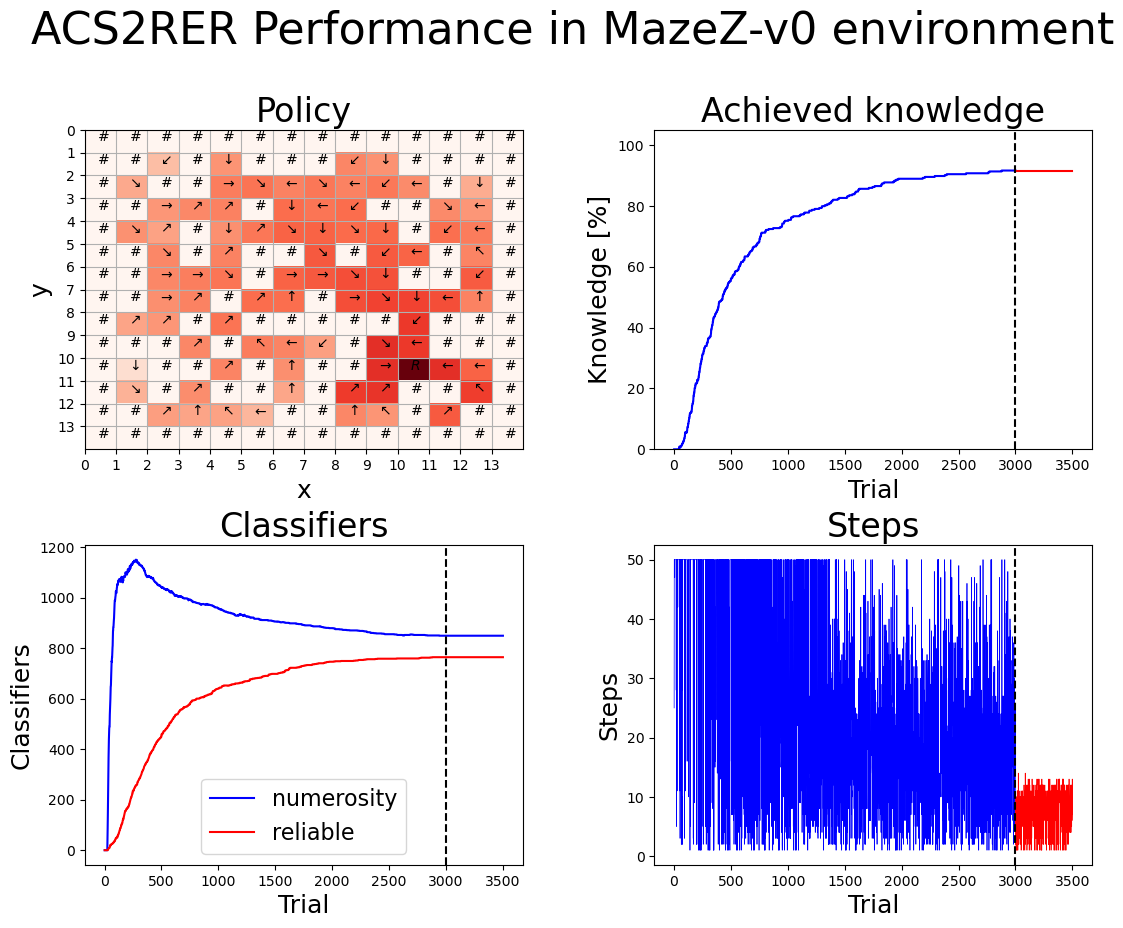

In [11]:
# maze5_metrics_df_acs2per = parse_metrics_to_df(acs2per_explore_metrics, acs2per_exploit_metrics)
# plot_performance(agent_acs2per, maze_acs2per, maze5_metrics_df_acs2per, MAZE, 'ACS2pER')

maze5_metrics_df_acs2rer = parse_metrics_to_df(acs2rer_explore_metrics, acs2rer_exploit_metrics)
plot_performance(agent_acs2rer, maze_acs2rer, maze5_metrics_df_acs2rer, MAZE, 'ACS2RER')

In [12]:
def plot_full_knowledge(df_acs2, df_acs2er):
    explore_df_acs2 = df_acs2.query("phase == 'explore'")
    exploit_df_acs2 = df_acs2.query("phase == 'exploit'")
    explore_df_acs2er = df_acs2er.query("phase == 'explore'")
    exploit_df_acs2er = df_acs2er.query("phase == 'exploit'")
    plt.axvline(x=len(explore_df_acs2), c='black', linestyle='dashed')
    x_axis_explore = range(len(explore_df_acs2))
    x_axis_exploit = range(len(explore_df_acs2), len(explore_df_acs2) + len(exploit_df_acs2))

    plt.title(f"Maze - Knowledge")
    plt.plot(x_axis_explore, explore_df_acs2er['knowledge'], c='r', label="ACS2ER", linewidth=1.5)
    plt.plot(x_axis_exploit, exploit_df_acs2er['knowledge'], c='r', linewidth=1.5)
    plt.plot(x_axis_explore, explore_df_acs2['knowledge'], c='#FF7575', label="ACS2", linewidth=1.5)
    plt.plot(x_axis_exploit, exploit_df_acs2['knowledge'], c='#FF7575', linewidth=1.5)
    plt.legend()
    plt.xlabel(f"Trial")
    plt.ylabel("Knowledge [%]")
    plt.show()


In [13]:
def plot_full_classifiers(df_acs2, df_acs2er):
    explore_df_acs2 = df_acs2.query("phase == 'explore'")
    exploit_df_acs2 = df_acs2.query("phase == 'exploit'")
    explore_df_acs2er = df_acs2er.query("phase == 'explore'")
    exploit_df_acs2er = df_acs2er.query("phase == 'exploit'")
    plt.axvline(x=len(explore_df_acs2), c='black', linestyle='dashed')
    x_axis_explore = range(len(explore_df_acs2))
    x_axis_exploit = range(len(explore_df_acs2), len(explore_df_acs2) + len(exploit_df_acs2))
   
    plt.title(f"Maze - Classifiers")
    plt.plot(x_axis_explore, explore_df_acs2er['numerosity'], c='b', label="ACS2ER - Numerosity", linewidth=1.5)
    plt.plot(x_axis_exploit, exploit_df_acs2er['numerosity'], c='b', linewidth=1.5)
    plt.plot(x_axis_explore, explore_df_acs2['numerosity'], c='#7579FF', label="ACS2 - Numerosity", linewidth=1.5)
    plt.plot(x_axis_exploit, exploit_df_acs2['numerosity'], c='#7579FF', linewidth=1.5)
    plt.plot(x_axis_explore, explore_df_acs2er['reliable'], c='r', label="ACS2ER - Reliable", linewidth=1.5)
    plt.plot(x_axis_exploit, exploit_df_acs2er['reliable'], c='r', linewidth=1.5)
    plt.plot(x_axis_explore, explore_df_acs2['reliable'], c='#FF7575', label="ACS2 - Reliable", linewidth=1.5)
    plt.plot(x_axis_exploit, exploit_df_acs2['reliable'], c='#FF7575', linewidth=1.5)
    plt.legend()
    plt.xlabel(f"Trial")
    plt.ylabel("Classifiers")
    plt.show()

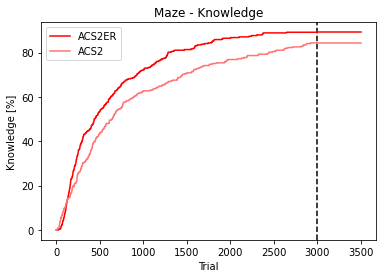

In [14]:
plot_full_knowledge(maze5_metrics_df_acs2, maze5_metrics_df_acs2er)

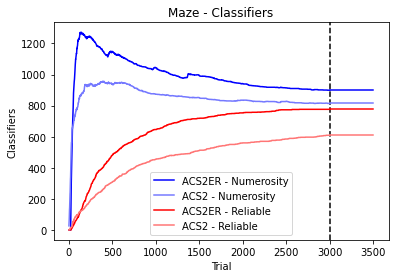

In [15]:
plot_full_classifiers(maze5_metrics_df_acs2, maze5_metrics_df_acs2er)

In [16]:
def average_steps(df_acs2, df_acs2er):
    exploit_df_acs2 = df_acs2.query("phase == 'exploit'")
    exploit_df_acs2er = df_acs2er.query("phase == 'exploit'")
    
    acs2_steps_avg = np.mean(np.array(exploit_df_acs2['steps']))
    acs2er_steps_avg = np.mean(np.array(exploit_df_acs2er['steps']))

    print(f"Steps ACS2: {acs2_steps_avg}")
    print(f"Steps ACS2ER: {acs2er_steps_avg}")

In [17]:
average_steps(maze5_metrics_df_acs2, maze5_metrics_df_acs2er)

Steps ACS2: 7.598
Steps ACS2ER: 8.368


In [18]:
def plot_full_steps(df_acs2, df_acs2er):
    exploit_df_acs2 = df_acs2.query("phase == 'exploit'")
    exploit_df_acs2er = df_acs2er.query("phase == 'exploit'")
    
    acs2_max_steps = np.max(exploit_df_acs2['steps'])
    acs2er_max_steps = np.max(exploit_df_acs2er['steps'])

    print(f"MAX Steps ACS2: {acs2_max_steps}")
    print(f"MAX Steps ACS2ER: {acs2er_max_steps}")


In [19]:
plot_full_steps(maze5_metrics_df_acs2, maze5_metrics_df_acs2er)

MAX Steps ACS2: 14
MAX Steps ACS2ER: 17
